# Статистика по индексу MIX на основе дней в месяце.

Статистика по направлениям свечей в зависимости от дня в месяце.

Подключение гугл диска

In [53]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Подключение к БД.

In [54]:
import pandas as pd
import numpy as np
import sqlite3
import datetime

In [55]:
connection = sqlite3.connect(r'/content/drive/MyDrive/data_quote_db/MIX_futures_day.db', check_same_thread=True)  # Создание соединения с БД

Загрузка данных в таблицу pandas.

In [56]:
with connection:
  df = pd.read_sql('SELECT * FROM Day', connection)  # Загрузка данных из БД

print(df.to_string(max_rows=6, max_cols=25))  # Проверка того, что загрузилось

       TRADEDATE      SECID      OPEN       LOW      HIGH     CLOSE  VOLUME  OPENPOSITION  SHORTNAME    LSTTRADE
0     2015-01-05  MXH5_2015  142000.0  138525.0  145950.0  145150.0    2587         12938   MIX-3.15  2015-03-16
1     2015-01-06  MXH5_2015  144750.0  144350.0  149900.0  149900.0    2953         12760   MIX-3.15  2015-03-16
2     2015-01-08  MXH5_2015  149500.0  148200.0  158200.0  156025.0    5567         15098   MIX-3.15  2015-03-16
...          ...        ...       ...       ...       ...       ...     ...           ...        ...         ...
2232  2023-11-30       MXZ3  317150.0  314350.0  319400.0  316375.0   54579        121210  MIX-12.23  2023-12-21
2233  2023-12-01       MXZ3  316025.0  313500.0  316850.0  314100.0   34534        121160  MIX-12.23  2023-12-21
2234  2023-12-04       MXZ3  313950.0  310775.0  314100.0  311125.0   42154        121720  MIX-12.23  2023-12-21


Подготовка DF

In [57]:
df = df.drop(['SECID', 'OPENPOSITION', 'SHORTNAME', 'LSTTRADE'], axis=1)
df['TRADEDATE'] = pd.to_datetime(df['TRADEDATE'])  # Смена типа
df = df.dropna().reset_index(drop=True)  # Удаление NaN
df = df.sort_values(by='TRADEDATE', ascending=False)  # Сортировка по убыванию

Создание и заполнение колонки с торговым днем месяца по убыванию.

In [58]:
df['Work_day'] = np.nan  # Создание колонки и заполнение NaN
month_cur = 0
n = 1
for i in range(0, len(df)):
  if i == 0:
    month_prev = df.iloc[0, 0].month
  month_cur = df.iloc[i, 0].month
  if month_cur != month_prev:
    n = 1

  df.iloc[i, df.columns.get_loc('Work_day')] = n
  n += 1
  month_prev = month_cur

df[['Work_day']] = df[['Work_day']].astype(int)
df = df.sort_values(by='TRADEDATE', ascending=True)  # Сортировка по возрастанию
print(df.to_string(max_rows=6, max_cols=25))  # Проверка

      TRADEDATE      OPEN       LOW      HIGH     CLOSE  VOLUME  Work_day
0    2015-01-05  142000.0  138525.0  145950.0  145150.0    2587        19
1    2015-01-06  144750.0  144350.0  149900.0  149900.0    2953        18
2    2015-01-08  149500.0  148200.0  158200.0  156025.0    5567        17
...         ...       ...       ...       ...       ...     ...       ...
2232 2023-11-30  317150.0  314350.0  319400.0  316375.0   54579         1
2233 2023-12-01  316025.0  313500.0  316850.0  314100.0   34534         2
2234 2023-12-04  313950.0  310775.0  314100.0  311125.0   42154         1


Отбрасываем последний (неполный) месяц.

In [59]:
year = df.iloc[-1, 0].year
month = df.iloc[-1, 0].month
end_date = datetime.datetime(year, month, 1)
df = df[df['TRADEDATE'] < end_date]
print(f'{year}-{month} отбрасываем этот месяц.')
print(df.to_string(max_rows=6, max_cols=25))  # Проверка

2023-12 отбрасываем этот месяц.
      TRADEDATE      OPEN       LOW      HIGH     CLOSE  VOLUME  Work_day
0    2015-01-05  142000.0  138525.0  145950.0  145150.0    2587        19
1    2015-01-06  144750.0  144350.0  149900.0  149900.0    2953        18
2    2015-01-08  149500.0  148200.0  158200.0  156025.0    5567        17
...         ...       ...       ...       ...       ...     ...       ...
2230 2023-11-28  318000.0  315525.0  320000.0  319300.0   35236         3
2231 2023-11-29  319300.0  316550.0  319975.0  317350.0   31695         2
2232 2023-11-30  317150.0  314350.0  319400.0  316375.0   54579         1


Добавление колонки направления бара.

In [60]:
# df['Up/Down'] = df.apply(lambda x: 1 if (x['OPEN'] < x['CLOSE']) else 0, axis=1)
df['Up'] = df.apply(lambda x: 1 if (x['OPEN'] < x['CLOSE']) else np.nan, axis=1)
df['Down'] = df.apply(lambda x: 1 if (x['OPEN'] >= x['CLOSE']) else np.nan, axis=1)
df['Body'] = df.apply(lambda x: -x['OPEN'] + x['CLOSE'], axis=1)
print(df.to_string(max_rows=6, max_cols=25))  # Проверка
# print('\n', df.value_counts("Up/Down"))

      TRADEDATE      OPEN       LOW      HIGH     CLOSE  VOLUME  Work_day   Up  Down    Body
0    2015-01-05  142000.0  138525.0  145950.0  145150.0    2587        19  1.0   NaN  3150.0
1    2015-01-06  144750.0  144350.0  149900.0  149900.0    2953        18  1.0   NaN  5150.0
2    2015-01-08  149500.0  148200.0  158200.0  156025.0    5567        17  1.0   NaN  6525.0
...         ...       ...       ...       ...       ...     ...       ...  ...   ...     ...
2230 2023-11-28  318000.0  315525.0  320000.0  319300.0   35236         3  1.0   NaN  1300.0
2231 2023-11-29  319300.0  316550.0  319975.0  317350.0   31695         2  NaN   1.0 -1950.0
2232 2023-11-30  317150.0  314350.0  319400.0  316375.0   54579         1  NaN   1.0  -775.0


Агрегация данных: подсчет количества баров на повышение и понижение по рабочену дню в месяце, суммирование размера тела свечи.

In [61]:
agg_func_count = {'Up': ['count'],
                  'Down': ['count'],
                  'Body': ['sum']}
df_count = df.groupby(['Work_day']).agg(agg_func_count)  # статистика по Up / Down
df_count

,Up,Down,Body
,count,count,sum
Work_day,,,
1,57,50,-5375.0
2,60,47,65850.0
3,61,46,-37525.0
4,57,50,26325.0
5,58,49,-8450.0
6,62,45,-14500.0
7,58,48,-24900.0
8,49,57,-34950.0


Создание колонки соотношения повышающихся и понижающихся баров.

In [62]:
df_count['Up-Down'] = df_count.apply(lambda x: x['Up'] - x['Down'], axis=1)
df_count[['Up-Down']] = df_count[['Up-Down']].astype(int)
df_count

,Up,Down,Body,Up-Down
,count,count,sum,
Work_day,,,,
1,57,50,-5375.0,7
2,60,47,65850.0,13
3,61,46,-37525.0,15
4,57,50,26325.0,7
5,58,49,-8450.0,9
6,62,45,-14500.0,17
7,58,48,-24900.0,10
8,49,57,-34950.0,-8


Расчет 75 перцентиля для определения выбросов вверх по сумме.  
Создание списка рабочих дней, когда произошли выбросы по сумме

In [63]:
perc75 = np.percentile(df_count['Body', 'sum'], 75)
print(perc75)
df_count = df_count.loc[df_count['Body', 'sum'] > perc75]
day_lst = list(df_count.index)
print(day_lst)
df_count

29937.5
[2, 11, 15, 19, 20, 21]


,Up,Down,Body,Up-Down
,count,count,sum,
Work_day,,,,
2,60,47,65850.0,13
11,54,52,31650.0,2
15,58,48,51125.0,10
19,54,49,37050.0,5
20,59,34,51250.0,25
21,46,30,77800.0,16


In [64]:
# df = df.loc[(df['Work_day'] >= 14) | (df['Work_day'] == 2)]  # Выборка по
# df = df.loc[df['Work_day'] >= 14]
# df = df.loc[df['Work_day'] == 2]
# df = df.loc[df['Work_day'].isin(day_lst)]
# df = df.loc[df['Work_day'] == 21]
df = df.loc[(df['Work_day'] == 20) | (df['Work_day'] == 21)]  # Выборка по

df["Body_cum"] = df["Body"].cumsum()
df

<ipython-input-64-86583c8e5e52>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Body_cum"] = df["Body"].cumsum()


,TRADEDATE,OPEN,LOW,HIGH,CLOSE,VOLUME,Work_day,Up,Down,Body,Body_cum
38,2015-03-02,177500.0,177175.0,180075.0,178500.0,9086,21,1.0,NaN,1000.0,1000.0
39,2015-03-03,178600.0,177450.0,183525.0,181450.0,13729,20,1.0,NaN,2850.0,3850.0
60,2015-04-02,168425.0,167425.0,170750.0,170750.0,15092,21,1.0,NaN,2325.0,6175.0
61,2015-04-03,170700.0,169725.0,171750.0,170300.0,10394,20,NaN,1.0,-400.0,5775.0
99,2015-06-01,163500.0,162075.0,164575.0,162625.0,16759,21,NaN,1.0,-875.0,4900.0
...,...,...,...,...,...,...,...,...,...,...,...
2169,2023-09-04,324750.0,324525.0,329650.0,329475.0,41148,20,1.0,NaN,4725.0,129600.0
2190,2023-10-03,317400.0,314500.0,318775.0,318675.0,54309,21,1.0,NaN,1275.0,130875.0
2191,2023-10-04,318500.0,316525.0,319750.0,316950.0,41656,20,NaN,1.0,-1550.0,129325.0
2212,2023-11-02,321525.0,319475.0,323250.0,320225.0,39705,21,NaN,1.0,-1300.0,128025.0


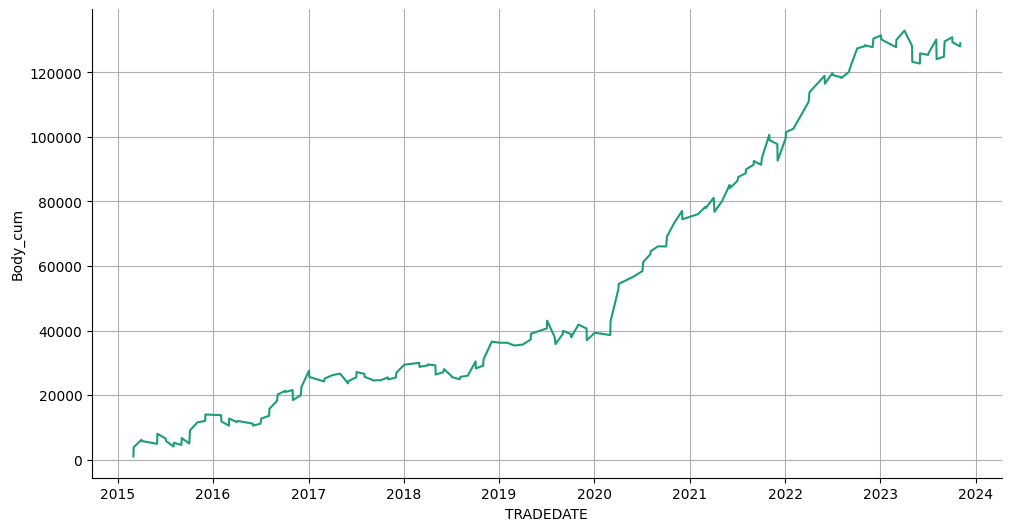

In [65]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['TRADEDATE']
  ys = series['Body_cum']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('TRADEDATE', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('TRADEDATE')
# plt.grid(axis='x')  # , color='0.95'
plt.grid()
_ = plt.ylabel('Body_cum')